In [4]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:

# Load dataset
df = pd.read_csv("parsed_games.csv")

cols_to_lower = ["Event", "Result", "ECO"]

for col in cols_to_lower:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x.lower().strip() if isinstance(x, str) else x)

# Extract game format (bullet, blitz, rapid, classical)
def extract_format(event):
    if pd.isna(event):
        return "unknown"
    if "bullet" in event:
        return "bullet"
    elif "blitz" in event:
        return "blitz"
    elif "rapid" in event:
        return "rapid"
    elif "classical" in event:
        return "classical"
    else:
        return "other"

def is_tournament_game(event):
    if pd.isna(event):
        return 0
    keywords = ["tournament", "tourney", "championship"]
    return int(any(k in event for k in keywords))

df["game_format"] = df["Event"].apply(extract_format)

df["is_tournament"] = df["Event"].apply(is_tournament_game)


# Remove duplicate entries (based on key identifiers)
df = df.drop_duplicates(subset=["White", "Black", "Moves"], keep="first")

# Identify critical and non-critical columns
critical_cols = ["White", "Black", "Result", "Moves"]
non_critical_cols = ["ECO", "Event"]

# Drop rows missing critical columns
df = df.dropna(subset=critical_cols)

# Fill missing non-critical columns with "unknown"
for col in non_critical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

# Remove games with very few or extremely high number of moves
df = df[(df["NumMoves"] >= 10) & (df["NumMoves"] <= 200)]



# Combine UTCDate and UTCTime into a single datetime column
if {'UTCDate', 'UTCTime'}.issubset(df.columns):
    df['UTCDatetime'] = pd.to_datetime(
        df['UTCDate'].astype(str) + ' ' + df['UTCTime'].astype(str),
        format='%Y.%m.%d %H:%M:%S',
        errors='coerce'   # safely handles invalid/missing entries
    )

    # Drop the now-redundant columns
    df.drop(columns=['UTCDate', 'UTCTime'], inplace=True)

df['NumMoves'] = (df['NumMoves'] // 2).astype(int)

#Export to CSV
df.to_csv("cleaned_games.csv", index=False)
print("Data cleaning complete! Cleaned file saved as 'cleaned_games.csv'.")

Data cleaning complete! Cleaned file saved as 'cleaned_games.csv'.


In [6]:
# Ensure essential columns are present and valid
required_columns = ["White", "Black", "Result", "Moves", "game_format", "is_tournament", "Date"]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print("Warning: Missing expected columns:", missing_columns)

In [7]:
print("Shape of cleaned dataset:", df.shape)
print("\nMissing values per column:")
print(df.isna().sum())

Shape of cleaned dataset: (196305, 15)

Missing values per column:
Event            0
Site             0
White            0
Black            0
Result           0
WhiteElo         0
BlackElo         0
ECO              0
Opening          0
NumMoves         0
Moves            0
Termination      0
game_format      0
is_tournament    0
UTCDatetime      0
dtype: int64


In [8]:
num_white_players = df["White"].nunique()
num_black_players = df["Black"].nunique()
unique_players = len(set(df["White"]).union(set(df["Black"])))

print(f"\nDistinct White players: {num_white_players}")
print(f"Distinct Black players: {num_black_players}")
print(f"Total unique players: {unique_players}")


Distinct White players: 24193
Distinct Black players: 23934
Total unique players: 26743


In [9]:
print("\nGame format distribution:")
print(df["game_format"].value_counts())
print("\nTournament game breakdown:")
print(df["is_tournament"].value_counts())
print("\nResult distribution:")
print(df["Result"].value_counts())


Game format distribution:
game_format
blitz        76391
bullet       74530
classical    44675
other          709
Name: count, dtype: int64

Tournament game breakdown:
is_tournament
0    159916
1     36389
Name: count, dtype: int64

Result distribution:
Result
1-0        98073
0-1        91413
1/2-1/2     6819
Name: count, dtype: int64


In [10]:
games_per_player = (
    pd.concat([df["White"], df["Black"]])
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Player", 0: "Games_Played"})
)
games_per_player.columns = ["Player", "Games_Played"]
print(games_per_player.head())

          Player  Games_Played
0       Dingo123           551
1  DrRobotvinnik           536
2       RazAlGul           472
3         Litium           431
4           TimC           423


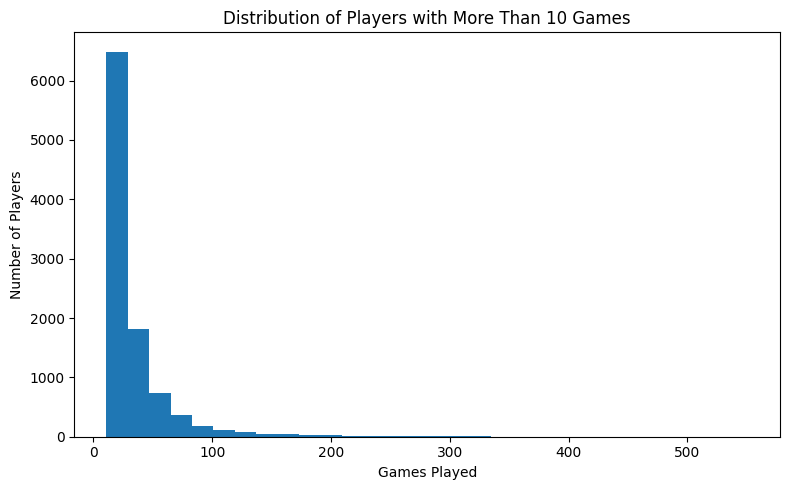

In [11]:
filtered = games_per_player[games_per_player["Games_Played"] > 10]

plt.figure(figsize=(8, 5))
plt.hist(filtered["Games_Played"], bins=30)
plt.title("Distribution of Players with More Than 10 Games")
plt.xlabel("Games Played")
plt.ylabel("Number of Players")
plt.tight_layout()
plt.show()

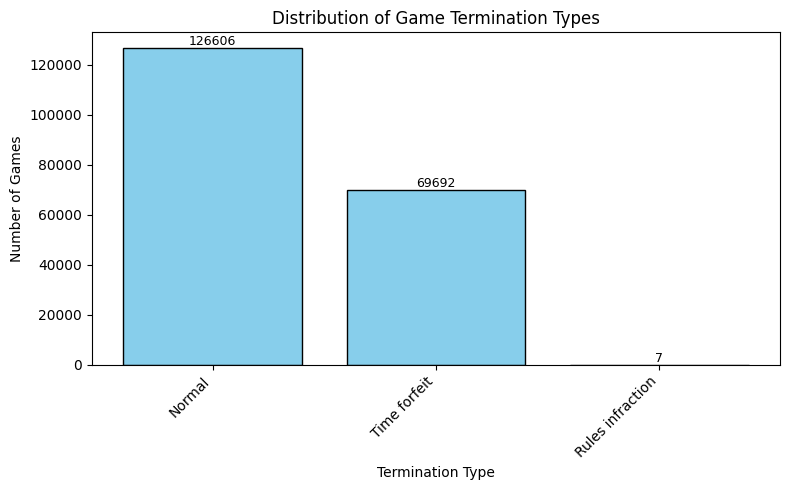

In [12]:
# Count occurrences of each termination type
termination_counts = df['Termination'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(termination_counts.index, termination_counts.values, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Distribution of Game Termination Types')
plt.xlabel('Termination Type')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')

# Add number labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [13]:
# Filter only Classical games
classical_df = df[df['game_format'] == 'classical']

# Count the number of games each player has played as White and Black
white_counts = classical_df['White'].value_counts()
black_counts = classical_df['Black'].value_counts()

# Combine counts (since a player can appear as both)
total_counts = white_counts.add(black_counts, fill_value=0)

# Select players with at least 15 Classical games
qualified_classical_players = total_counts[total_counts >= 15].index.tolist()

print(f"Number of players with ≥30 Classical games: {len(qualified_classical_players)}")

Number of players with ≥30 Classical games: 1444


In [14]:
import pandas as pd

# Step 1: Read the original cleaned dataset
df = pd.read_csv('cleaned_games.csv')

# Step 2: Remove all bullet and blitz games
# Assuming 'TimeControl' or 'Event' column indicates format (adjust if named differently)
# You can modify the condition depending on how the format is stored in your file
df = df[~df['game_format'].str.contains('bullet|blitz', case=False, na=False)]

# Step 3: Create a new dataframe with one row per player (white and black separately)
white_df = df.copy()
black_df = df.copy()

# White player entries
white_df['username'] = white_df['White']
white_df['Colour'] = 'White'

# Black player entries
black_df['username'] = black_df['Black']
black_df['Colour'] = 'Black'

# Step 4: Combine both
combined_df = pd.concat([white_df, black_df], ignore_index=True)

# Step 5: Drop the old player columns
combined_df = combined_df.drop(columns=['White', 'Black'])

# Step 6: Sort by username alphabetically
combined_df = combined_df.sort_values(by='username', ascending=True).reset_index(drop=True)

# Step 7: Save to new CSV file
combined_df.to_csv('classical_games.csv', index=False)

print("classical_games.csv created successfully!")
print(f"Total rows in new dataset: {len(combined_df)}")


classical_games.csv created successfully!
Total rows in new dataset: 90768


In [15]:
import pandas as pd

# Step 1: Read the existing classical dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Count the number of games per player
game_counts = df['username'].value_counts()

# Step 3: Keep only players with >= 10 games
valid_players = game_counts[game_counts >= 10].index
filtered_df = df[df['username'].isin(valid_players)].copy()

# Step 4: Add a helper column for number of games (for sorting)
filtered_df['GamesPlayed'] = filtered_df['username'].map(game_counts)

# Step 5: Sort by number of games (descending), then username (ascending for ties)
filtered_df = filtered_df.sort_values(by=['GamesPlayed', 'username'], ascending=[False, True]).reset_index(drop=True)

# Step 6: Drop the helper column (optional)
filtered_df = filtered_df.drop(columns=['GamesPlayed'])

# Step 7: Save to new CSV file
filtered_df.to_csv('classical_games.csv', index=False)

print("✅ classical_games.csv updated successfully!")
print(f"Total players remaining: {filtered_df['username'].nunique()}")
print(f"Total rows remaining: {len(filtered_df)}")


✅ classical_games.csv updated successfully!
Total players remaining: 2877
Total rows remaining: 52175


In [16]:
import pandas as pd

# Read the current dataset
df = pd.read_csv('classical_games.csv')

# Count games with less than 20 moves
short_games_count = (df['NumMoves'] < 10).sum()

print(f"🕹️ Number of games with less than 10 moves: {short_games_count}")


🕹️ Number of games with less than 10 moves: 2107


In [17]:
import pandas as pd

# Step 1: Read the dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Remove games with fewer than 10 moves
initial_count = len(df)
df = df[df['NumMoves'] >= 10].copy()
removed_count = initial_count - len(df)

# Step 3: Save the cleaned dataset
df.to_csv('classical_games.csv', index=False)

print(f"Remaining games: {len(df)}")

Remaining games: 50068


In [18]:
import pandas as pd

# Step 1: Read the dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Compute absolute Elo difference
df['EloDiff'] = (df['WhiteElo'] - df['BlackElo']).abs()

# Step 3: Count games with difference > 250
elo_diff_count = (df['EloDiff'] > 250).sum()

print(f"🎯 Number of games with Elo difference > 250: {elo_diff_count}")

🎯 Number of games with Elo difference > 250: 8414


In [19]:
import pandas as pd

# Step 1: Read the dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Compute absolute Elo difference
df['EloDiff'] = (df['WhiteElo'] - df['BlackElo']).abs()

# Step 3: Filter out games with Elo difference > 250
initial_count = len(df)
df = df[df['EloDiff'] <= 250].copy()
removed_count = initial_count - len(df)

# Step 4: Drop the helper column (optional)
df = df.drop(columns=['EloDiff'])

# Step 5: Save the filtered dataset
df.to_csv('classical_games.csv', index=False)

print(f"✅ Removed {removed_count} games with Elo difference > 250.")
print(f"Remaining games: {len(df)}")


✅ Removed 8414 games with Elo difference > 250.
Remaining games: 41654


In [20]:
import pandas as pd

# Step 1: Read the dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Filter games with less than 20 moves and terminated by time forfeit
mask = (df['NumMoves'] < 20) & (df['Termination'].str.contains('time forfeit', case=False, na=False))
count_time_forfeit = mask.sum()

print(f"⏱️ Number of games with <20 moves and termination = 'time forfeit': {count_time_forfeit}")


⏱️ Number of games with <20 moves and termination = 'time forfeit': 942


In [21]:
import pandas as pd

# Step 1: Read the dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Define the mask for unwanted games
mask = (df['NumMoves'] < 20) & (df['Termination'].str.contains('time forfeit', case=False, na=False))

# Step 3: Remove them
initial_count = len(df)
df = df[~mask].copy()
removed_count = initial_count - len(df)

# Step 4: Save the cleaned dataset
df.to_csv('classical_games.csv', index=False)

print(f"✅ Removed {removed_count} games with <20 moves and termination = 'time forfeit'.")
print(f"Remaining games: {len(df)}")


✅ Removed 942 games with <20 moves and termination = 'time forfeit'.
Remaining games: 40712


In [22]:
import pandas as pd

# Step 1: Read the cleaned dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Count number of games per player
game_counts = df['username'].value_counts()

# Step 3: Filter players with more than 30 games
players_over_30 = game_counts[game_counts > 18]

# Step 4: Display results
print(f"👥 Number of players with more than 15 games: {len(players_over_30)}")

👥 Number of players with more than 15 games: 606


In [23]:
import pandas as pd

# Step 1: Read the cleaned dataset
df = pd.read_csv('classical_games.csv')

# Step 2: Count games per player
game_counts = df['username'].value_counts()

# Step 3: Select players with at least 8 games as White and 8 as Black
eligible_players = []
for player in game_counts.index:
    player_games = df[df['username'] == player]
    white_count = (player_games['Colour'].str.lower() == 'white').sum()
    black_count = (player_games['Colour'].str.lower() == 'black').sum()
    if white_count >= 8 and black_count >= 8:
        eligible_players.append(player)

# Step 4: Take the top 50 eligible players
selected_players = eligible_players[:]

# Step 5: Sample 8 games as White and 8 as Black for each player
samples = []
for player in selected_players:
    player_games = df[df['username'] == player]
    white_games = player_games[player_games['Colour'].str.lower() == 'white'].sample(n=8, random_state=42)
    black_games = player_games[player_games['Colour'].str.lower() == 'black'].sample(n=8, random_state=42)
    samples.append(pd.concat([white_games, black_games]))

# Step 6: Combine all samples
training_df = pd.concat(samples).reset_index(drop=True)

# Step 7: Save to CSV
training_df.to_csv('feature_extract.csv', index=False)

print(f"✅ Created 'feature_extract.csv' with {len(selected_players)} players × 16 games each = {len(training_df)} total games.")


✅ Created 'feature_extract.csv' with 630 players × 16 games each = 10080 total games.
